<a href="https://colab.research.google.com/github/Baeji1/Level-Set/blob/master/Image_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set path to directory


In [0]:
%cd ./drive/My\ Drive
%pwd

/content/drive/My Drive


'/content/drive/My Drive'

### Imports


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
import os
import cv2 as cv
import numpy as np
import keras
from IPython.display import display, clear_output
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Input
from keras.models import Model
# from keras import backend as K
cv.__version__

'4.1.2'

### Image Format Functions and Callbacks



In [0]:
def offsetROI(offset,img):
  x1,y1 = 155,68
  x2,y2 = 411,372
  roi = img[y1+offset[1]:y2+offset[3],x1+offset[0]:x2+offset[2]]
  return roi

def showMe(img,title):
  plt.imshow(img.astype(np.uint8))
  plt.title(title)
  plt.show()
  print(img.shape)
  return

def convertTime(time):
  day = time // (24 * 3600)
  time = time % (24 * 3600)
  hour = time // 3600
  time %= 3600
  minutes = time // 60
  time %= 60
  seconds = time
  time = "{:.0f}d :{:.0f}h :{:.0f}m :{:.0f}s".format(day, hour, minutes, seconds)
  return time


class PrintLogs(keras.callbacks.Callback):
  def __init__(self, epochs):
    self.epochs = epochs
    self.wait_dict = {}
    self.wait_dict['clear_iterations'] = 500
    self.wait_dict['print_iterations'] = 50
    self.wait_dict['track_time'] = time.time()
  
  def set_params(self, params):
    params['epochs'] = 0

  def on_epoch_begin(self, epoch, logs=None):
    if(epoch +1)%self.wait_dict['clear_iterations'] == 0:
      clear_output(wait=True)
    
    if(epoch +1)%self.wait_dict['print_iterations'] == 0:
      print(' Epoch %d/%d' % (epoch + 1, self.epochs),end=' ')
      
  def on_epoch_end(self, epoch, logs=None):
    if(epoch+1)%self.wait_dict['print_iterations'] == 0:
      print(' Loss: {:.3f}   Time: {:.3f}'.format(logs['loss'],time.time() - self.wait_dict['track_time']))
      self.wait_dict['track_time'] = time.time()



### Image Test


In [0]:
# img_path = 'test_image.jpg'
# img = cv.imread(img_path)

x_offset = 0
y_offset = 0
original = offsetROI([x_offset,y_offset,x_offset,y_offset],img)
# showMe(original,'Original')

x_offset = 337
y_offset = 0
contour = offsetROI([x_offset,y_offset,x_offset,y_offset],img)
# showMe(contour,'Contour')

x_offset = 337
y_offset = 425
nucleus = offsetROI([x_offset,y_offset,x_offset,y_offset],img)
# showMe(nucleus,'Nucleus')

x_offset = 674
y_offset = 425
result = offsetROI([x_offset,y_offset,x_offset,y_offset],img)
# showMe(result,'Result')

print(' Loaded all sub-images with shape {}\n\n'.format(original.shape))

 Loaded all sub-images with shape (304, 256, 3)




###  Nucleus Model



In [0]:
def nucleus_model(input_shape):
  model = Sequential()
  model.add(InputLayer(input_shape=input_shape))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
  return model


### Training


In [0]:
original = original
target = result

(x_train,y_train),(x_test,y_test) = (original,target),(original,target)
(x_train,y_train),(x_test,y_test) = (x_train/255,y_train/255),(x_test/255,y_test/255)

input_shape = x_train.shape
x_train = np.array([x_train])
y_train = np.array([y_train])
centroidModel = nucleus_model(input_shape)
centroidModel.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
# centroidModel.summary()

start_time = time.time()

epochs = 5000
batch_size = 1

centroidModel.fit(x=x_train, 
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=[PrintLogs(epochs)])

end_time = time.time()
print(' \n Training start time: {}'.format(time.ctime(start_time)))
print(' Training end time: {}\n'.format(time.ctime(end_time)))
total = convertTime(end_time-start_time)
print(' Total training time: {} \n'.format(total))


 Epoch 5000/5000  Loss: 0.005   Time: 8.444
 
 Training start time: Thu Mar 19 10:03:34 2020
 Training end time: Thu Mar 19 10:17:36 2020

 Total training time: 0d :0h :14m :2s 



### Output

 Training time: 0d :0h :14m :2s

 Training Results:


 Prediction shape: (1, 304, 256, 3)



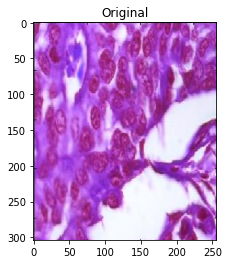

(304, 256, 3)


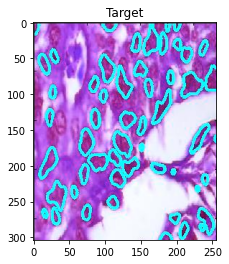

(304, 256, 3)


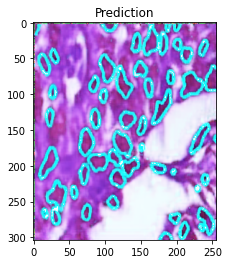

(304, 256, 3)


In [0]:
prediction = centroidModel.predict(x_train)
print(' Training time: {}'.format(total))
print('\n Training Results:\n\n')
print(f' Prediction shape: {prediction.shape}\n')

prediction *= 255

showMe(original,'Original')
showMe(target,'Target')
showMe(prediction[0],'Prediction')

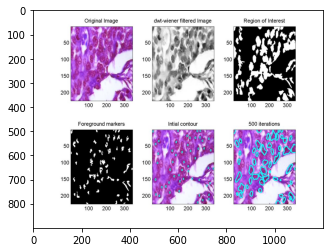

(900, 1200, 3)


In [0]:
plt.imshow(img)
plt.show()
print(img.shape)
